# Part A: Single-Program Architecture Sentiment Analyzer

This notebook implements sentiment analysis using a **single-program architecture**.
The program reads a dataset, processes each line sequentially, classifies sentiment, and aggregates results.

**Architectural characteristics:**
- Simple, monolithic design
- Sequential processing
- Direct data flow
- Single pass through data

## 1) Configuration and Setup

In [8]:
import csv
import re
from collections import defaultdict
from typing import List, Set, Dict
from enum import Enum
import matplotlib.pyplot as plt
from pydantic import BaseModel, ValidationError, field_validator

# Dataset path
DATA_PATH = 'data/sample_us_posts.txt'
KEYWORDS_PATH = 'data/keywords.csv'

print(f'Using dataset: {DATA_PATH}')
print(f'Using keywords: {KEYWORDS_PATH}')

Using dataset: data/sample_us_posts.txt
Using keywords: data/keywords.csv


## 2) Models and Keyword Loading

In [9]:
# Define Pydantic models for type safety and validation
class SentimentType(str, Enum):
    """Enumeration for sentiment types"""
    POSITIVE = "Positive"
    NEGATIVE = "Negative"
    MIXED = "Mixed"
    NEUTRAL = "Neutral"

class KeywordSet(BaseModel):
    """Model for keyword sets with validation"""
    positive: Set[str]
    negative: Set[str]
    
    @field_validator('positive', 'negative', mode='after')
    @classmethod
    def validate_keywords(cls, v: Set[str]) -> Set[str]:
        if not v:
            raise ValueError("Keyword set cannot be empty")
        return {keyword.lower() for keyword in v}

class Post(BaseModel):
    """Model for a social media post"""
    text: str
    tokens: List[str] = []
    
    @field_validator('text', mode='after')
    @classmethod
    def validate_text(cls, v: str) -> str:
        if not v.strip():
            raise ValueError("Post text cannot be empty")
        return v.strip()

class SentimentResult(BaseModel):
    """Model for sentiment classification result"""
    post: Post
    sentiment: SentimentType
    has_positive: bool
    has_negative: bool
    matched_positive: Set[str] = set()
    matched_negative: Set[str] = set()

class SentimentSummary(BaseModel):
    """Model for aggregated sentiment results"""
    positive: int = 0
    negative: int = 0
    mixed: int = 0
    neutral: int = 0
    total_posts: int = 0
    verdict: str = ""
    
    @field_validator('total_posts', mode='after')
    @classmethod
    def validate_total_posts(cls, v: int) -> int:
        if v < 0:
            raise ValueError("Total posts cannot be negative")
        return v
    
    def calculate_verdict(self) -> str:
        """Calculate and set the verdict based on positive vs negative counts"""
        if self.positive > self.negative:
            self.verdict = 'Happier'
        elif self.negative > self.positive:
            self.verdict = 'Sadder'
        else:
            self.verdict = 'Tied'
        return self.verdict

def load_keywords(keywords_path: str) -> KeywordSet:
    """Load positive and negative keywords from CSV file using Pydantic model."""
    positive_keywords = set()
    negative_keywords = set()
    
    with open(keywords_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            keyword = row['keyword'].lower()
            sentiment = row['sentiment'].lower()
            
            if sentiment == 'positive':
                positive_keywords.add(keyword)
            elif sentiment == 'negative':
                negative_keywords.add(keyword)
    
    return KeywordSet(positive=positive_keywords, negative=negative_keywords)

# Load keywords using Pydantic model
try:
    keywords = load_keywords(KEYWORDS_PATH)
    print(f'Positive keywords: {keywords.positive}')
    print(f'Negative keywords: {keywords.negative}')
    print(f'Keywords model type: {type(keywords)}')
except ValidationError as e:
    print(f"Validation error loading keywords: {e}")
except Exception as e:
    print(f"Error loading keywords: {e}")

Positive keywords: {'excited', 'thrilled', 'happy', 'love'}
Negative keywords: {'upset', 'depressed', 'sad', 'angry'}
Keywords model type: <class '__main__.KeywordSet'>


## 3) Sentiment Classifier

In [ ]:
def tokenize(text: str) -> List[str]:
    """Simple tokenization: letters and apostrophes only, case-insensitive."""
    words = re.findall(r"[a-zA-Z']+", text.lower())
    return words

def classify_sentiment(post_text: str, keywords: KeywordSet) -> SentimentResult:
    """Classify sentiment"""
    try:
        # Create Post object with validation
        post = Post(text=post_text)
        post.tokens = tokenize(post_text)
        
        # Convert tokens to set for efficient intersection
        token_set = set(post.tokens)
        
        # Find keyword matches
        matched_positive = token_set & keywords.positive
        matched_negative = token_set & keywords.negative
        
        # Determine sentiment based on matches
        has_positive = bool(matched_positive)
        has_negative = bool(matched_negative)
        
        if has_positive and has_negative:
            sentiment = SentimentType.MIXED
        elif has_positive:
            sentiment = SentimentType.POSITIVE
        elif has_negative:
            sentiment = SentimentType.NEGATIVE
        else:
            sentiment = SentimentType.NEUTRAL
        
        # Create and return SentimentResult object
        return SentimentResult(
            post=post,
            sentiment=sentiment,
            has_positive=has_positive,
            has_negative=has_negative,
            matched_positive=matched_positive,
            matched_negative=matched_negative
        )
    
    except ValidationError as e:
        print(f"Validation error in classify_sentiment: {e}")
        # Return neutral result for invalid posts
        neutral_post = Post(text="[INVALID POST]")
        return SentimentResult(
            post=neutral_post,
            sentiment=SentimentType.NEUTRAL,
            has_positive=False,
            has_negative=False
        )

# Test the classifier
test_cases = [
    "I am so happy today!",
    "I feel sad and depressed.",
    "I love this but I'm also upset.",
    "The weather is nice.",
    "",  # Test empty string validation
    "   "  # Test whitespace-only validation
]

print("Testing classifier with validation:")
for i, test in enumerate(test_cases):
    try:
        result = classify_sentiment(test, keywords)
        print(f'  {i+1}. "{test}" -> {result.sentiment.value}')
        if result.matched_positive:
            print(f'    Positive matches: {result.matched_positive}')
        if result.matched_negative:
            print(f'    Negative matches: {result.matched_negative}')
    except Exception as e:
        print(f'  {i+1}. "{test}" -> Error: {e}')
    print()

Testing Pydantic-based classifier with validation:
  1. "I am so happy today!" -> Positive
    Positive matches: {'happy'}

  2. "I feel sad and depressed." -> Negative
    Negative matches: {'depressed', 'sad'}

  3. "I love this but I'm also upset." -> Mixed
    Positive matches: {'love'}
    Negative matches: {'upset'}

  4. "The weather is nice." -> Neutral

Validation error in classify_sentiment: 1 validation error for Post
text
  Value error, Post text cannot be empty [type=value_error, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
  5. "" -> Neutral

Validation error in classify_sentiment: 1 validation error for Post
text
  Value error, Post text cannot be empty [type=value_error, input_value='   ', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
  6. "   " -> Neutral



## 4) Main Processing Function

In [ ]:
def analyze_sentiment_file(file_path: str, keywords: KeywordSet) -> SentimentSummary:
    """Analyze sentiment file."""
    summary = SentimentSummary()
    processed_results: List[SentimentResult] = []
    
    print(f"Processing {file_path}...")
    
    # Single pass through the data
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if line:  # Skip empty lines
                try:
                    # Classify
                    result = classify_sentiment(line, keywords)
                    processed_results.append(result)
                    
                    # Update summary counts based on sentiment type
                    if result.sentiment == SentimentType.POSITIVE:
                        summary.positive += 1
                    elif result.sentiment == SentimentType.NEGATIVE:
                        summary.negative += 1
                    elif result.sentiment == SentimentType.MIXED:
                        summary.mixed += 1
                    else:
                        summary.neutral += 1
                    
                    summary.total_posts += 1
                    
                    # Progress indicator for large files
                    if line_num % 1000 == 0:
                        print(f"  Processed {line_num} lines...")
                        
                except Exception as e:
                    print(f"  Error processing line {line_num}: {e}")
                    continue
    
    # Calculate verdict
    summary.calculate_verdict()
    
    print(f"Completed processing {summary.total_posts} posts.")
    print(f"Sample results (first 3 classifications):")
    for i, result in enumerate(processed_results[:3]):
        print(f"  {i+1}. \"{result.post.text[:50]}...\" -> {result.sentiment.value}")
        if result.matched_positive:
            print(f"     Positive: {result.matched_positive}")
        if result.matched_negative:
            print(f"     Negative: {result.matched_negative}")
    
    return summary

# Process the dataset using Pydantic models
results = analyze_sentiment_file(DATA_PATH, keywords)
print(f"\\Summary Object: {results}")
print(f"Results type: {type(results)}")

Processing data/sample_us_posts.txt using Pydantic models...
Completed processing 10 posts.
Sample results (first 3 classifications):
  1. "I am so happy to be here in the United States!..." -> Positive
     Positive: {'happy'}
  2. "Feeling excited about the new semester in Dallas...." -> Positive
     Positive: {'excited'}
  3. "Today was rough. I feel sad and tired...." -> Negative
     Negative: {'sad'}
\nPydantic Summary Object: positive=5 negative=2 mixed=2 neutral=1 total_posts=10 verdict='Happier'
Results type: <class '__main__.SentimentSummary'>


## 5) Generate Output and Verdict Using Pydantic

In [15]:
def print_results(summary: SentimentSummary) -> str:
    """Print results in the required format using Pydantic model."""
    # Required output format
    print(f"Positive={summary.positive} Negative={summary.negative} Mixed={summary.mixed} Neutral={summary.neutral}")
    print(f"Verdict: {summary.verdict}")
    
    # Additional Pydantic model information
    print(f"\nModel Details:")
    print(f"  Total Posts: {summary.total_posts}")
    print(f"  Model JSON: {summary.model_dump_json()}")
    
    return summary.verdict

# Generate and print results using Pydantic model
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
verdict = print_results(results)


FINAL RESULTS
Positive=5 Negative=2 Mixed=2 Neutral=1
Verdict: Happier

Model Details:
  Total Posts: 10
  Model JSON: {"positive":5,"negative":2,"mixed":2,"neutral":1,"total_posts":10,"verdict":"Happier"}


## 6) Visualization

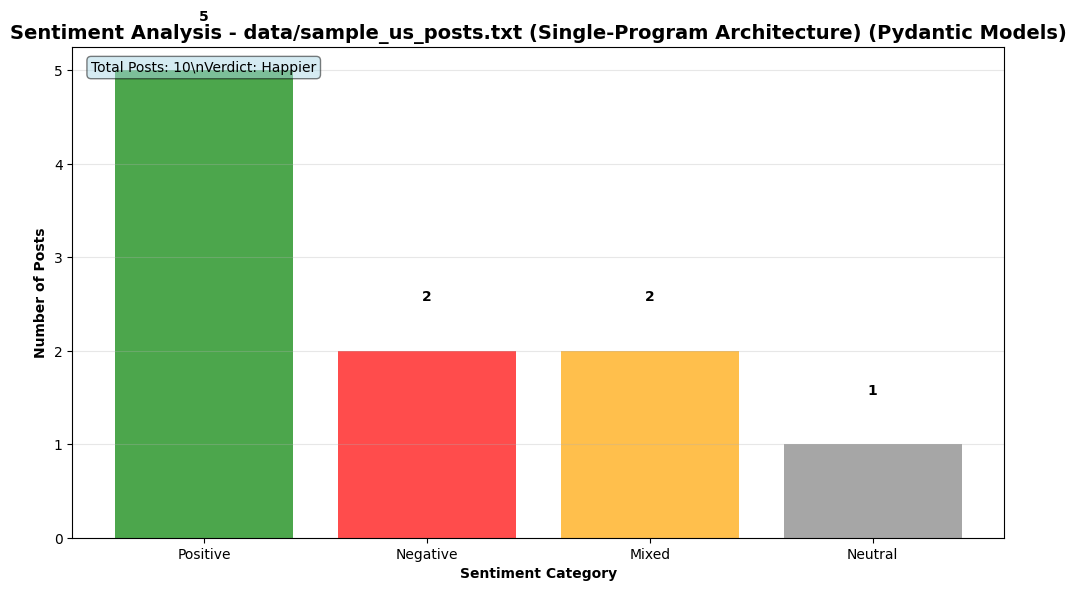

In [ ]:
def create_bar_chart(summary: SentimentSummary, title: str = "Sentiment Analysis Results"):
    """Create a bar chart"""
    labels = ['Positive', 'Negative', 'Mixed', 'Neutral']
    values = [summary.positive, summary.negative, summary.mixed, summary.neutral]
    colors = ['green', 'red', 'orange', 'gray']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.title(f"{title}", fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment Category', fontweight='bold')
    plt.ylabel('Number of Posts', fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Add summary information using Pydantic model
    info_text = f'Total Posts: {summary.total_posts}\\nVerdict: {summary.verdict}'
    plt.text(0.02, 0.95, info_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Create visualization using Pydantic model data
create_bar_chart(results, f"Sentiment Analysis - {DATA_PATH} (Single-Program Architecture)")

## 7) Test with Different Datasets


TESTING WITH: data/sample_us_posts_mixed.txt
Processing data/sample_us_posts_mixed.txt using Pydantic models...
Completed processing 15 posts.
Sample results (first 3 classifications):
  1. "So happy about the new job, but a bit sad to leave..." -> Mixed
     Positive: {'happy'}
     Negative: {'sad'}
  2. "Excited for the concert tonight!..." -> Positive
     Positive: {'excited'}
  3. "Feeling depressed after the storm damage in our ne..." -> Negative
     Negative: {'depressed'}
Positive=7 Negative=4 Mixed=2 Neutral=2
Verdict: Happier

Model Details:
  Total Posts: 15
  Model JSON: {"positive":7,"negative":4,"mixed":2,"neutral":2,"total_posts":15,"verdict":"Happier"}


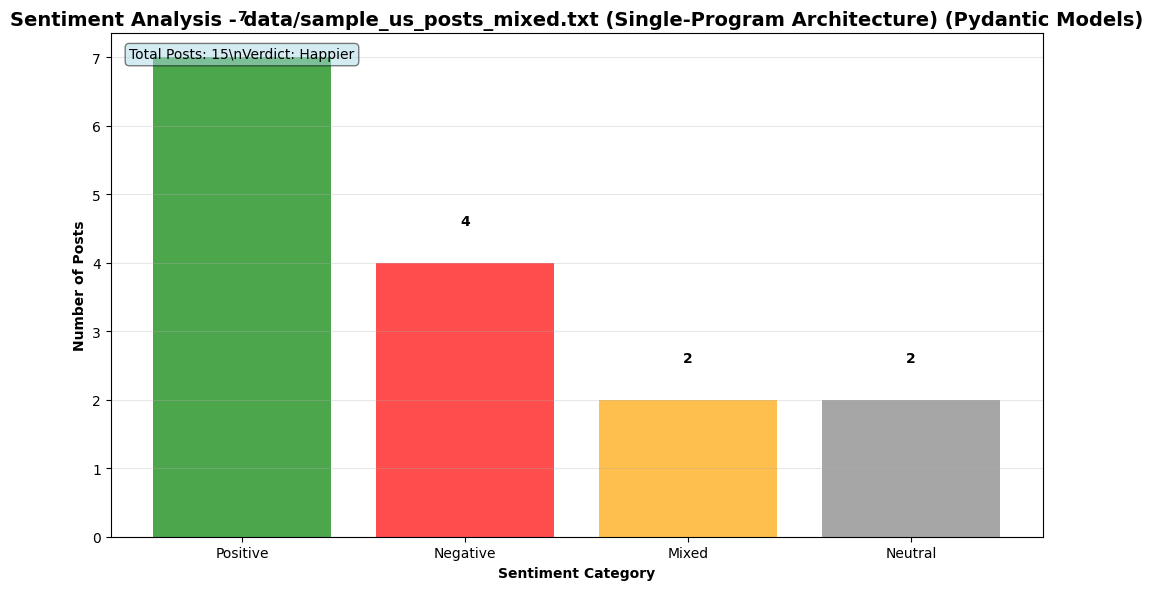


Comparison between datasets:
Original dataset verdict: Happier
Mixed dataset verdict: Happier


In [18]:
MIXED_DATA_PATH = 'data/sample_us_posts_mixed.txt'

try:
    print("\n" + "="*50)
    print(f"TESTING WITH: {MIXED_DATA_PATH}")
    print("="*50)
    
    mixed_results = analyze_sentiment_file(MIXED_DATA_PATH, keywords)
    mixed_verdict = print_results(mixed_results)
    
    # Create chart for mixed dataset using Pydantic model
    create_bar_chart(mixed_results, f"Sentiment Analysis - {MIXED_DATA_PATH} (Single-Program Architecture)")
    
    # Compare results using Pydantic model capabilities
    print(f"\nComparison between datasets:")
    print(f"Original dataset verdict: {results.verdict}")
    print(f"Mixed dataset verdict: {mixed_results.verdict}")
    
except FileNotFoundError:
    print(f"Mixed dataset {MIXED_DATA_PATH} not found. Skipping...")